# Classification. Linear models and KNN

In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math, time, random, datetime

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn import model_selection, tree, preprocessing, metrics, linear_model


# Graphics in Retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina' 

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

%matplotlib inline

In [8]:
#pip install catboost

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [9]:
# importing data to GDOC
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# accessing data via GDOC
data_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RS_School/ml-intro-2021/ml-intro-2021/5_classification_linear_knn/titanic/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RS_School/ml-intro-2021/ml-intro-2021/5_classification_linear_knn/titanic/test.csv')

In [11]:
#PATH = "./data/"

In [12]:
#data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [13]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

#### Some of the explorations of the Dataset

In [14]:
# investigate the data via the simple buil-in stats methods 
data_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Ridsdale, Miss. Lucy",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [15]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [16]:
# Checking the shape of DF (also visiable via info method)
data_train.shape, data_test.shape

((891, 12), (418, 11))

In [17]:
# Checking the amount of NaN's for train dataset
from tabulate import tabulate

top = 15
print(tabulate(
    sorted(list(zip(data_train.columns, data_train.isnull().sum(), data_train.isnull().sum() / data_train.shape[0] * 100)), key=lambda x: -x[2])[:top], 
    headers=['col_name', 'null_cnt', 'null_perc']))

col_name       null_cnt    null_perc
-----------  ----------  -----------
Cabin               687    77.1044
Age                 177    19.8653
Embarked              2     0.224467
PassengerId           0     0
Survived              0     0
Pclass                0     0
Name                  0     0
Sex                   0     0
SibSp                 0     0
Parch                 0     0
Ticket                0     0
Fare                  0     0


In [18]:
# Checking the amount of NaN's for test dataset
from tabulate import tabulate

top = 15
print(tabulate(
    sorted(list(zip(data_test.columns, data_test.isnull().sum(), data_test.isnull().sum() / data_test.shape[0] * 100)), key=lambda x: -x[2])[:top], 
    headers=['col_name', 'null_cnt', 'null_perc']))

col_name       null_cnt    null_perc
-----------  ----------  -----------
Cabin               327    78.2297
Age                  86    20.5742
Fare                  1     0.239234
PassengerId           0     0
Pclass                0     0
Name                  0     0
Sex                   0     0
SibSp                 0     0
Parch                 0     0
Ticket                0     0
Embarked              0     0


##### Visualization of some features in the Dataset

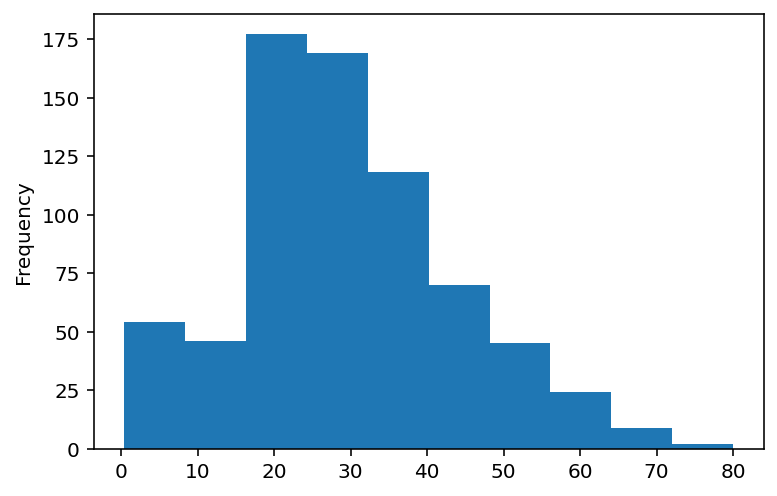

In [19]:
# check some columns for the distributions 
data_train.Age.plot.hist()

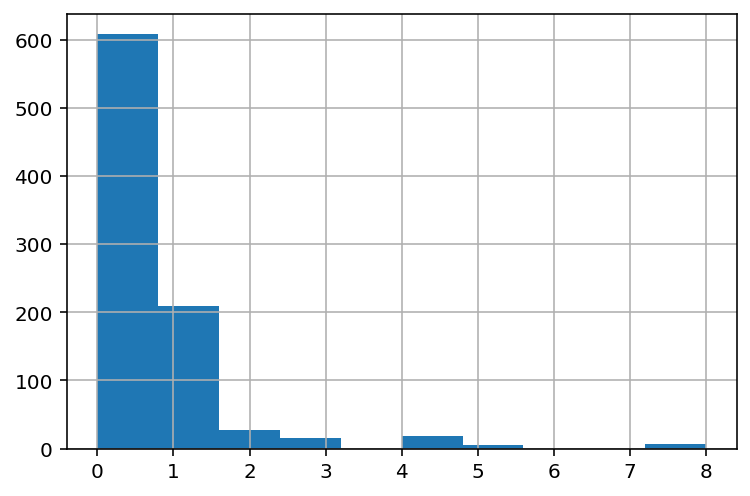

In [20]:
# check some columns for the distributions 
data_train.SibSp.hist()

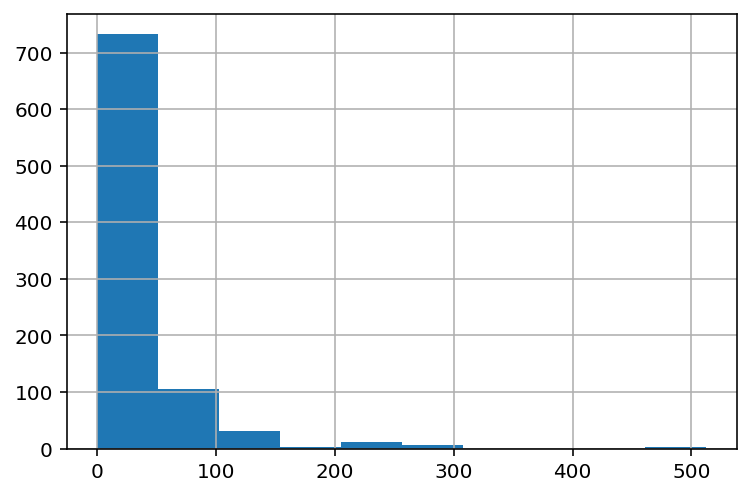

In [21]:
# check some columns for the distributions 
data_train.Fare.hist()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


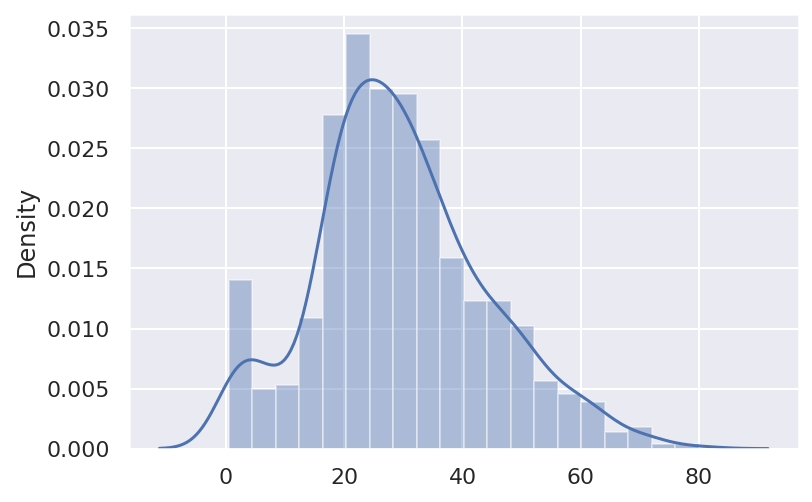

In [22]:
# A quick overview using Seaborn
import seaborn as sns
sns.set()

sns.distplot(data_train[['Age']]);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


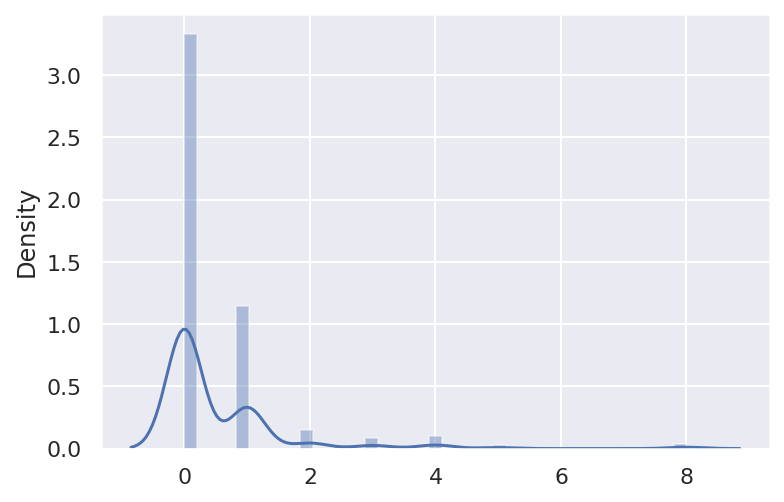

In [23]:
sns.distplot(data_train[['SibSp']]);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


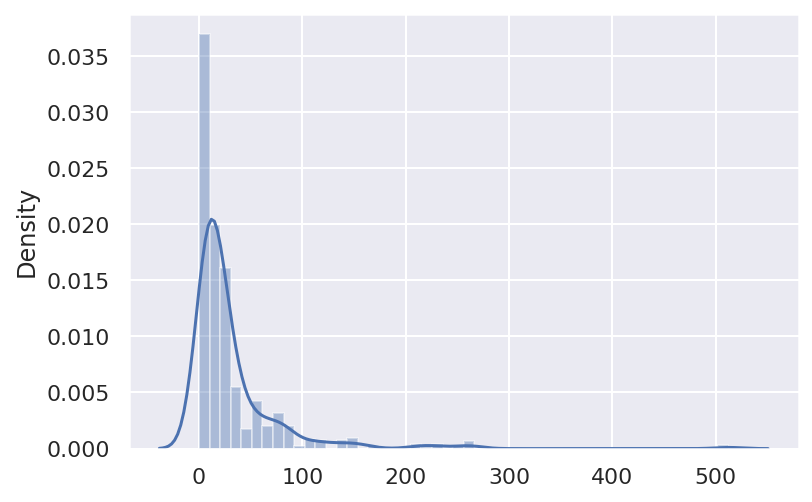

In [24]:
sns.distplot(data_train[['Fare']]);

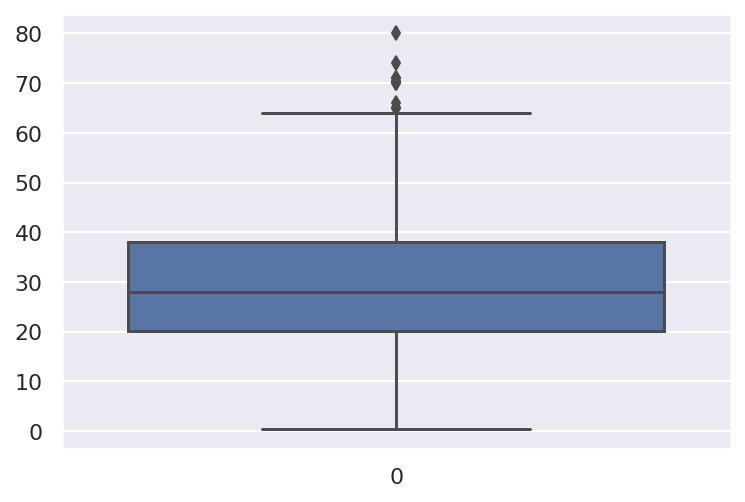

In [25]:
# Checking for the outliers for Age
sns.boxplot(data = data_train['Age'])

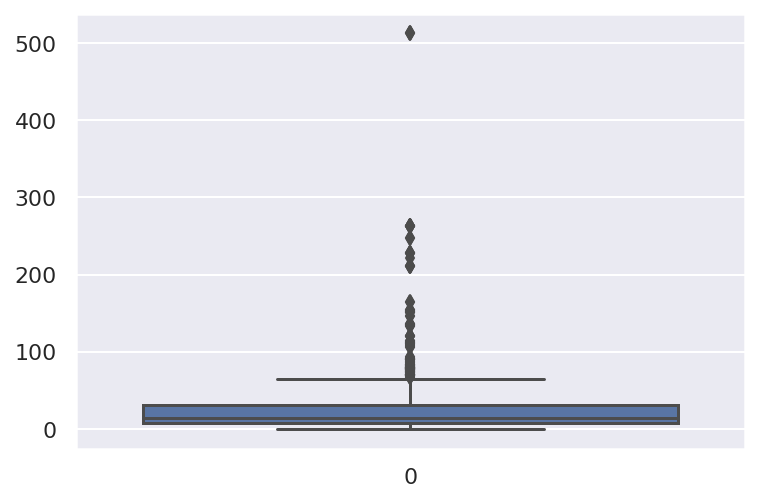

In [26]:
# Checking for the outliers for Fare
sns.boxplot(data = data_train['Fare'])

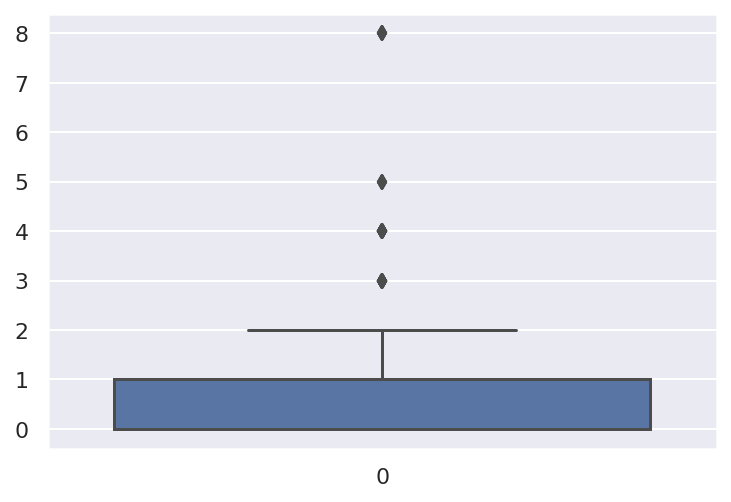

In [27]:
# Checking for the outliers for SibSp
sns.boxplot(data = data_train['SibSp'])

In [28]:
data_train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [29]:
data_train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [30]:
# Convering

### A part for the Homework for EDA section

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [31]:
# What about the survived passengers?
data_train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [32]:
# How many females and males are there in the dataset?
data_train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [33]:
# Converting Sex feature to a binary one
data_train.Sex = np.where(data_train.Sex == 'male', 0, 1) # male == 0, female ==1
data_test.Sex = np.where(data_test.Sex == 'male', 0, 1) # male == 0, female ==1

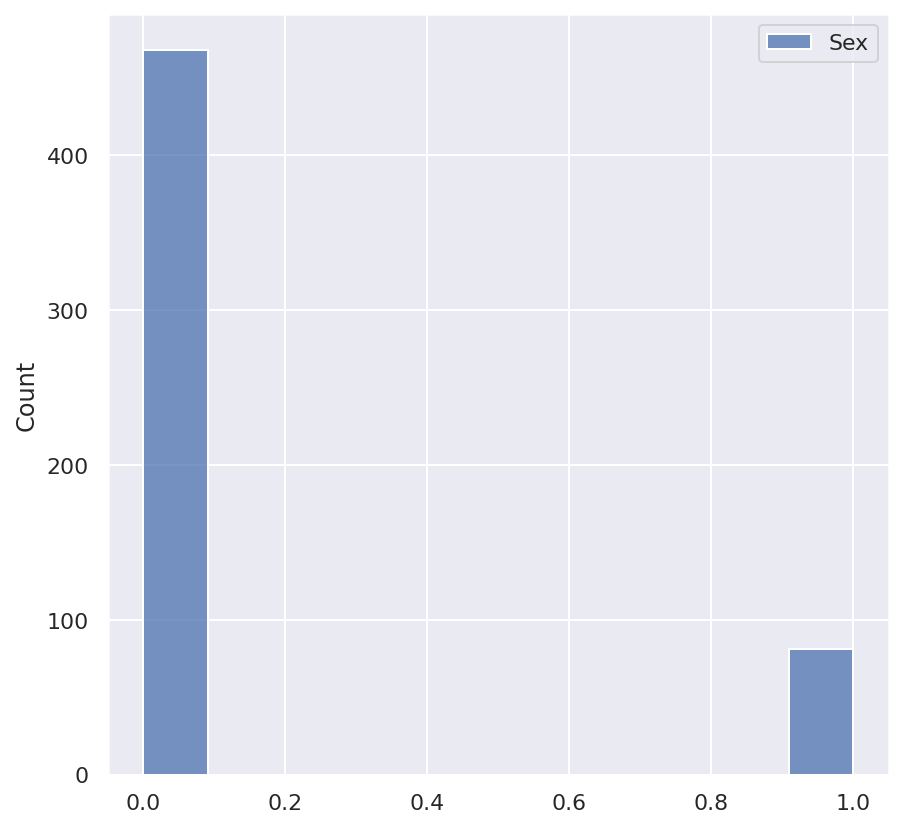

In [34]:
# Single Chart for not survived passengers
fig = plt.figure(figsize=(7, 7))
sns.histplot(data_train.loc[data_train['Survived'] == 0][['Sex']]);

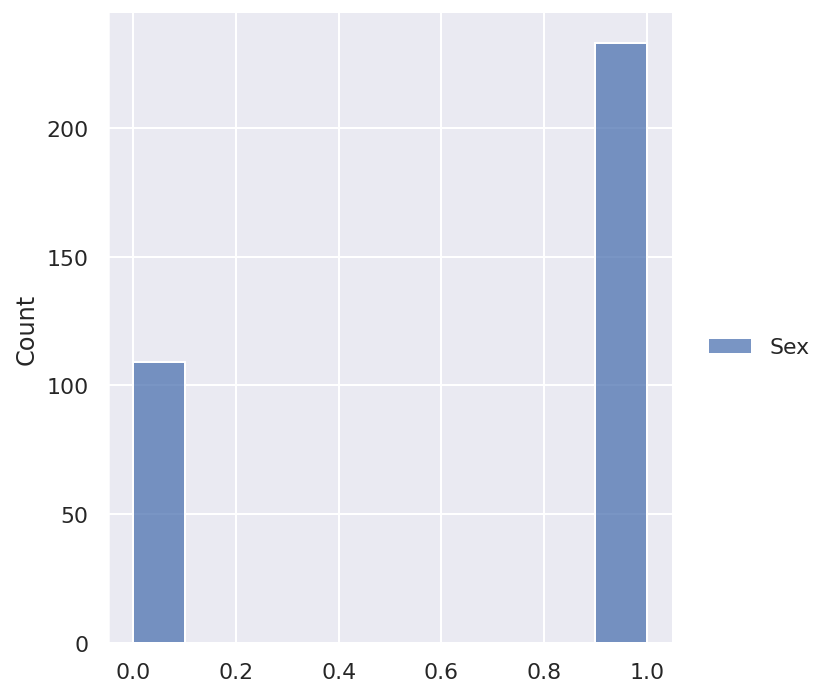

In [35]:
# Single Chart for not survived passengers
sns.displot(data_train.loc[data_train['Survived'] == 1][['Sex']]);

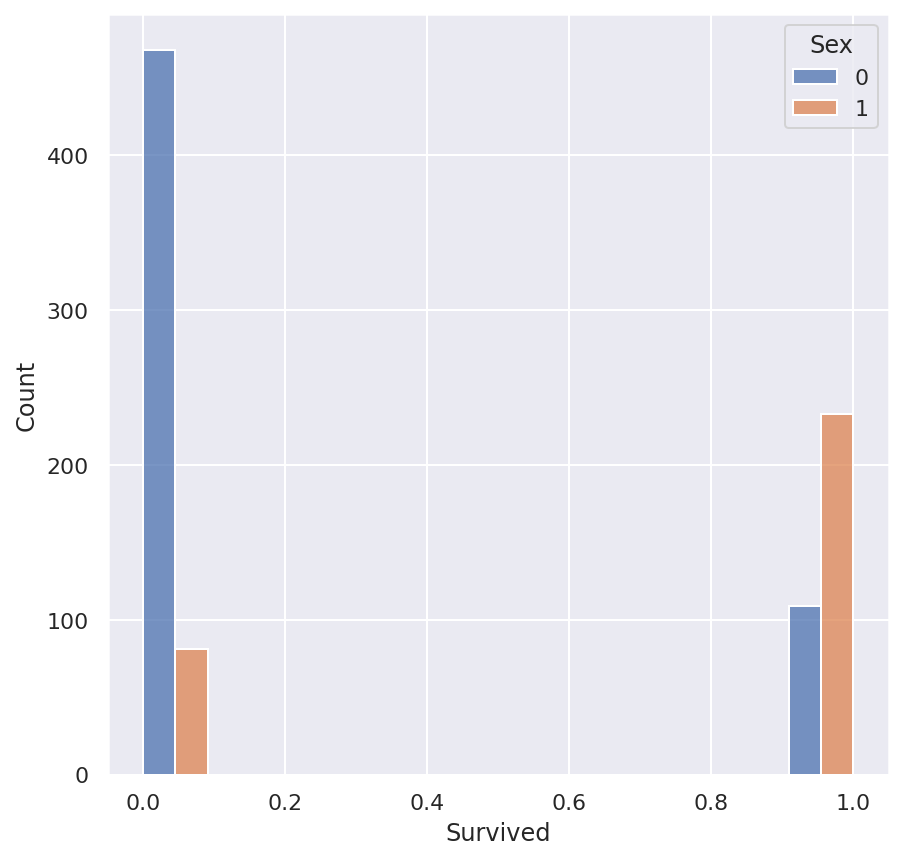

In [36]:
# Combined Chart for all passengers - this one is easy to follow
# not survived == 0; survied == 1; male == 0; female == 1;
fig = plt.figure(figsize=(7, 7))
sns.histplot(data=data_train, x="Survived", hue="Sex", multiple="dodge")

From the charts above we can see that not many people survived. But of those who did, more were female.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

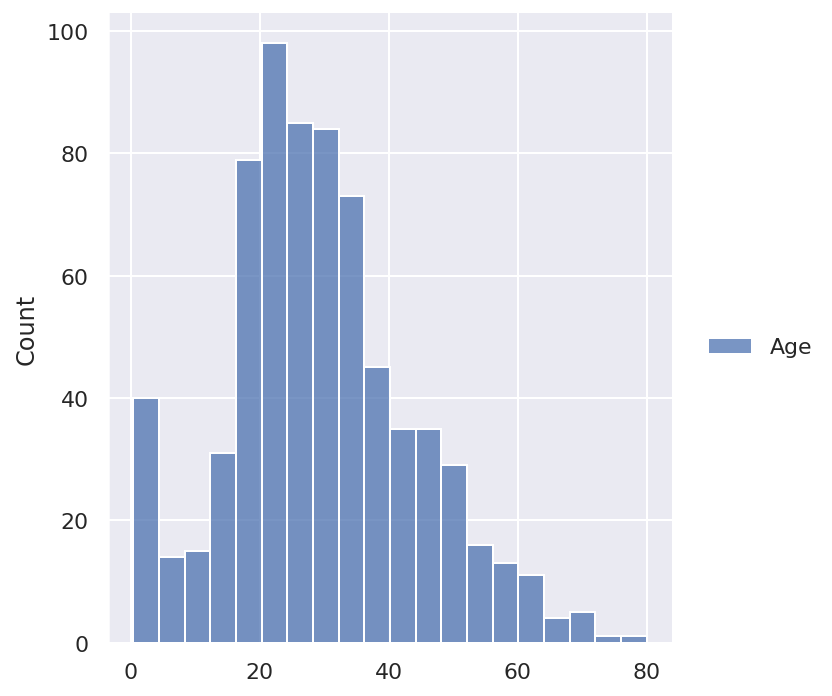

In [37]:
# Visualizatipn
sns.displot(data_train[['Age']]);

In [38]:
# Mean Age of not survived passangers
data_train.loc[data_train['Survived'] == 0]['Age'].mean()

30.62617924528302

In [39]:
# Mean Age of survived passangers
data_train.loc[data_train['Survived'] == 1]['Age'].mean()

28.343689655172415

In [40]:
# Median Age of not survived passangers
data_train.loc[data_train['Survived'] == 0]['Age'].median()

28.0

In [41]:
# Median Age of survived passangers
data_train.loc[data_train['Survived'] == 1]['Age'].median()

28.0

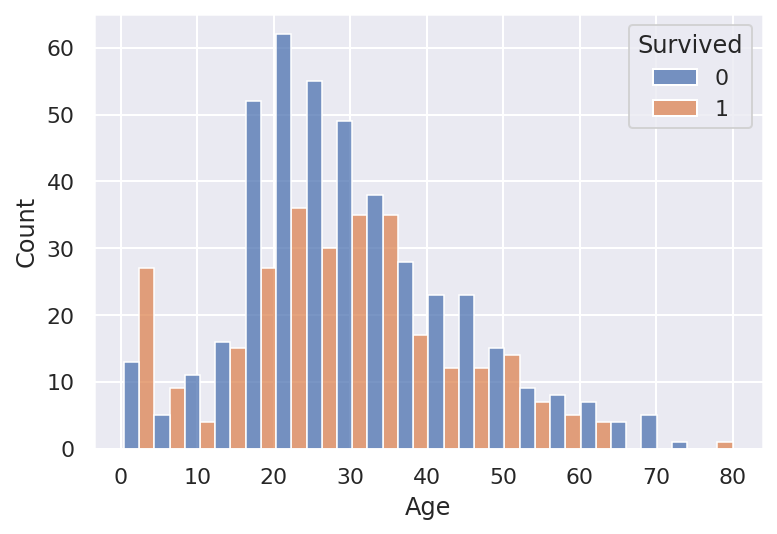

In [42]:
# Age distribution for deseased and survived passangers 
sns.histplot(data=data_train, x="Age", hue="Survived", multiple="dodge")

In case of the age distribution between survived and not survived passangers we can notice a bit of skewneed to the left in the distribution for the survived passenagers; meaning that the those who were younger survived more frequently in contrast with elderly passengers. Especially, we can see this for todlers (age == 0).
The reason we have such a difference could be that mature passengers decided to switch their sits in a safe boat with toddlers and, perhaps, womens. It's a hypothesis, we can degist it from the data, but we could make an assumption about that.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [43]:
data_train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [44]:
data_train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [45]:
data_train.loc[(data_train['Survived'] == 1) & (data_train['Pclass'] == 1)].count()

PassengerId    136
Survived       136
Pclass         136
Name           136
Sex            136
Age            122
SibSp          136
Parch          136
Ticket         136
Fare           136
Cabin          117
Embarked       134
dtype: int64

In [46]:
data_train.loc[(data_train['Survived'] == 1) & (data_train['Pclass'] == 2)].count()

PassengerId    87
Survived       87
Pclass         87
Name           87
Sex            87
Age            83
SibSp          87
Parch          87
Ticket         87
Fare           87
Cabin          13
Embarked       87
dtype: int64

In [47]:
data_train.loc[(data_train['Survived'] == 1) & (data_train['Pclass'] == 3)].count()

PassengerId    119
Survived       119
Pclass         119
Name           119
Sex            119
Age             85
SibSp          119
Parch          119
Ticket         119
Fare           119
Cabin            6
Embarked       119
dtype: int64

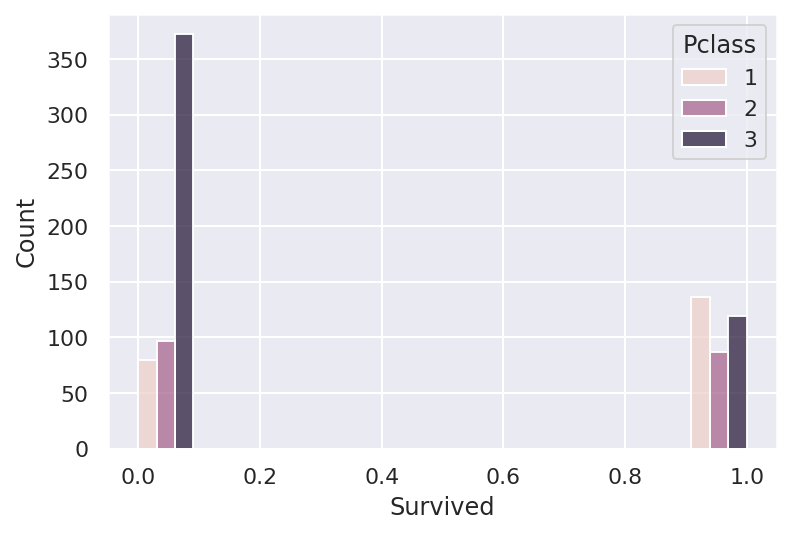

In [48]:
# The distribution of Pclass and Survived passengers
sns.histplot(data=data_train, x="Survived", hue="Pclass", multiple="dodge")

According to the picture above the safest class is Pclass 1 with 136 survivors; Pclass 2 has 87 survivors and Pclass 3 has 119 survivors.

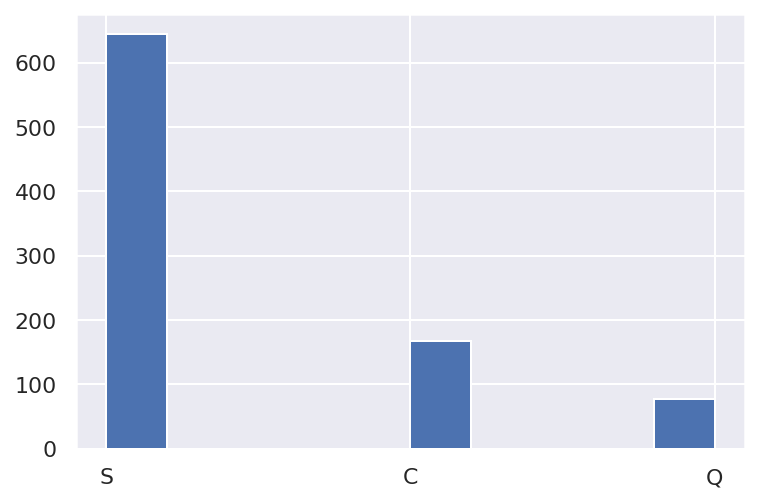

In [49]:
# The hist plot of the Embarked passangers
data_train.Embarked.hist()

In [50]:
data_train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

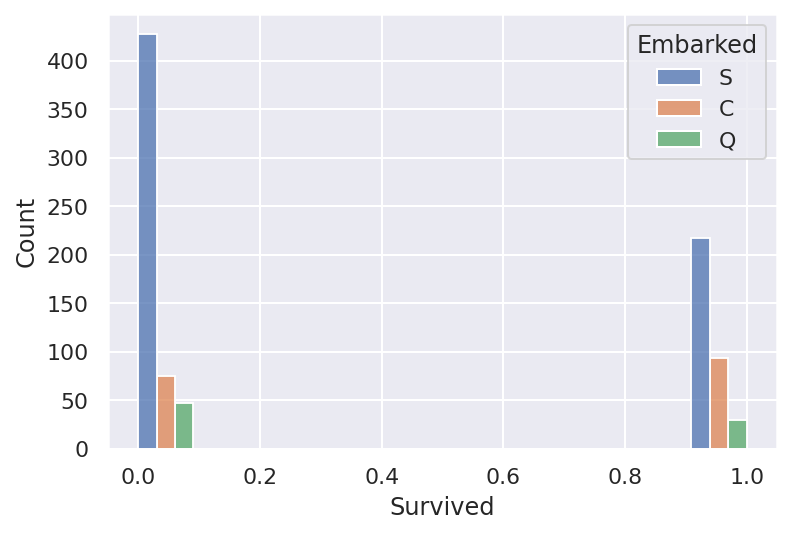

In [51]:
# The distribution of Embarked and Survived passengers
sns.histplot(data=data_train, x="Survived", hue="Embarked", multiple="dodge")

Interestingly enough that the distribution of the Embarked passengers is the same for those who survived and those who don't. As we can see from the plot above, the most of survivors have embarked at the place "S", the least number of survivors have embarked at the place "Q". 

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [52]:
# Checking the amount of NaN's for train dataset
from tabulate import tabulate

top = 15
print(tabulate(
    sorted(list(zip(data_train.columns, data_train.isnull().sum(), data_train.isnull().sum() / data_train.shape[0] * 100)), key=lambda x: -x[2])[:top], 
    headers=['col_name', 'null_cnt', 'null_perc']))

col_name       null_cnt    null_perc
-----------  ----------  -----------
Cabin               687    77.1044
Age                 177    19.8653
Embarked              2     0.224467
PassengerId           0     0
Survived              0     0
Pclass                0     0
Name                  0     0
Sex                   0     0
SibSp                 0     0
Parch                 0     0
Ticket                0     0
Fare                  0     0


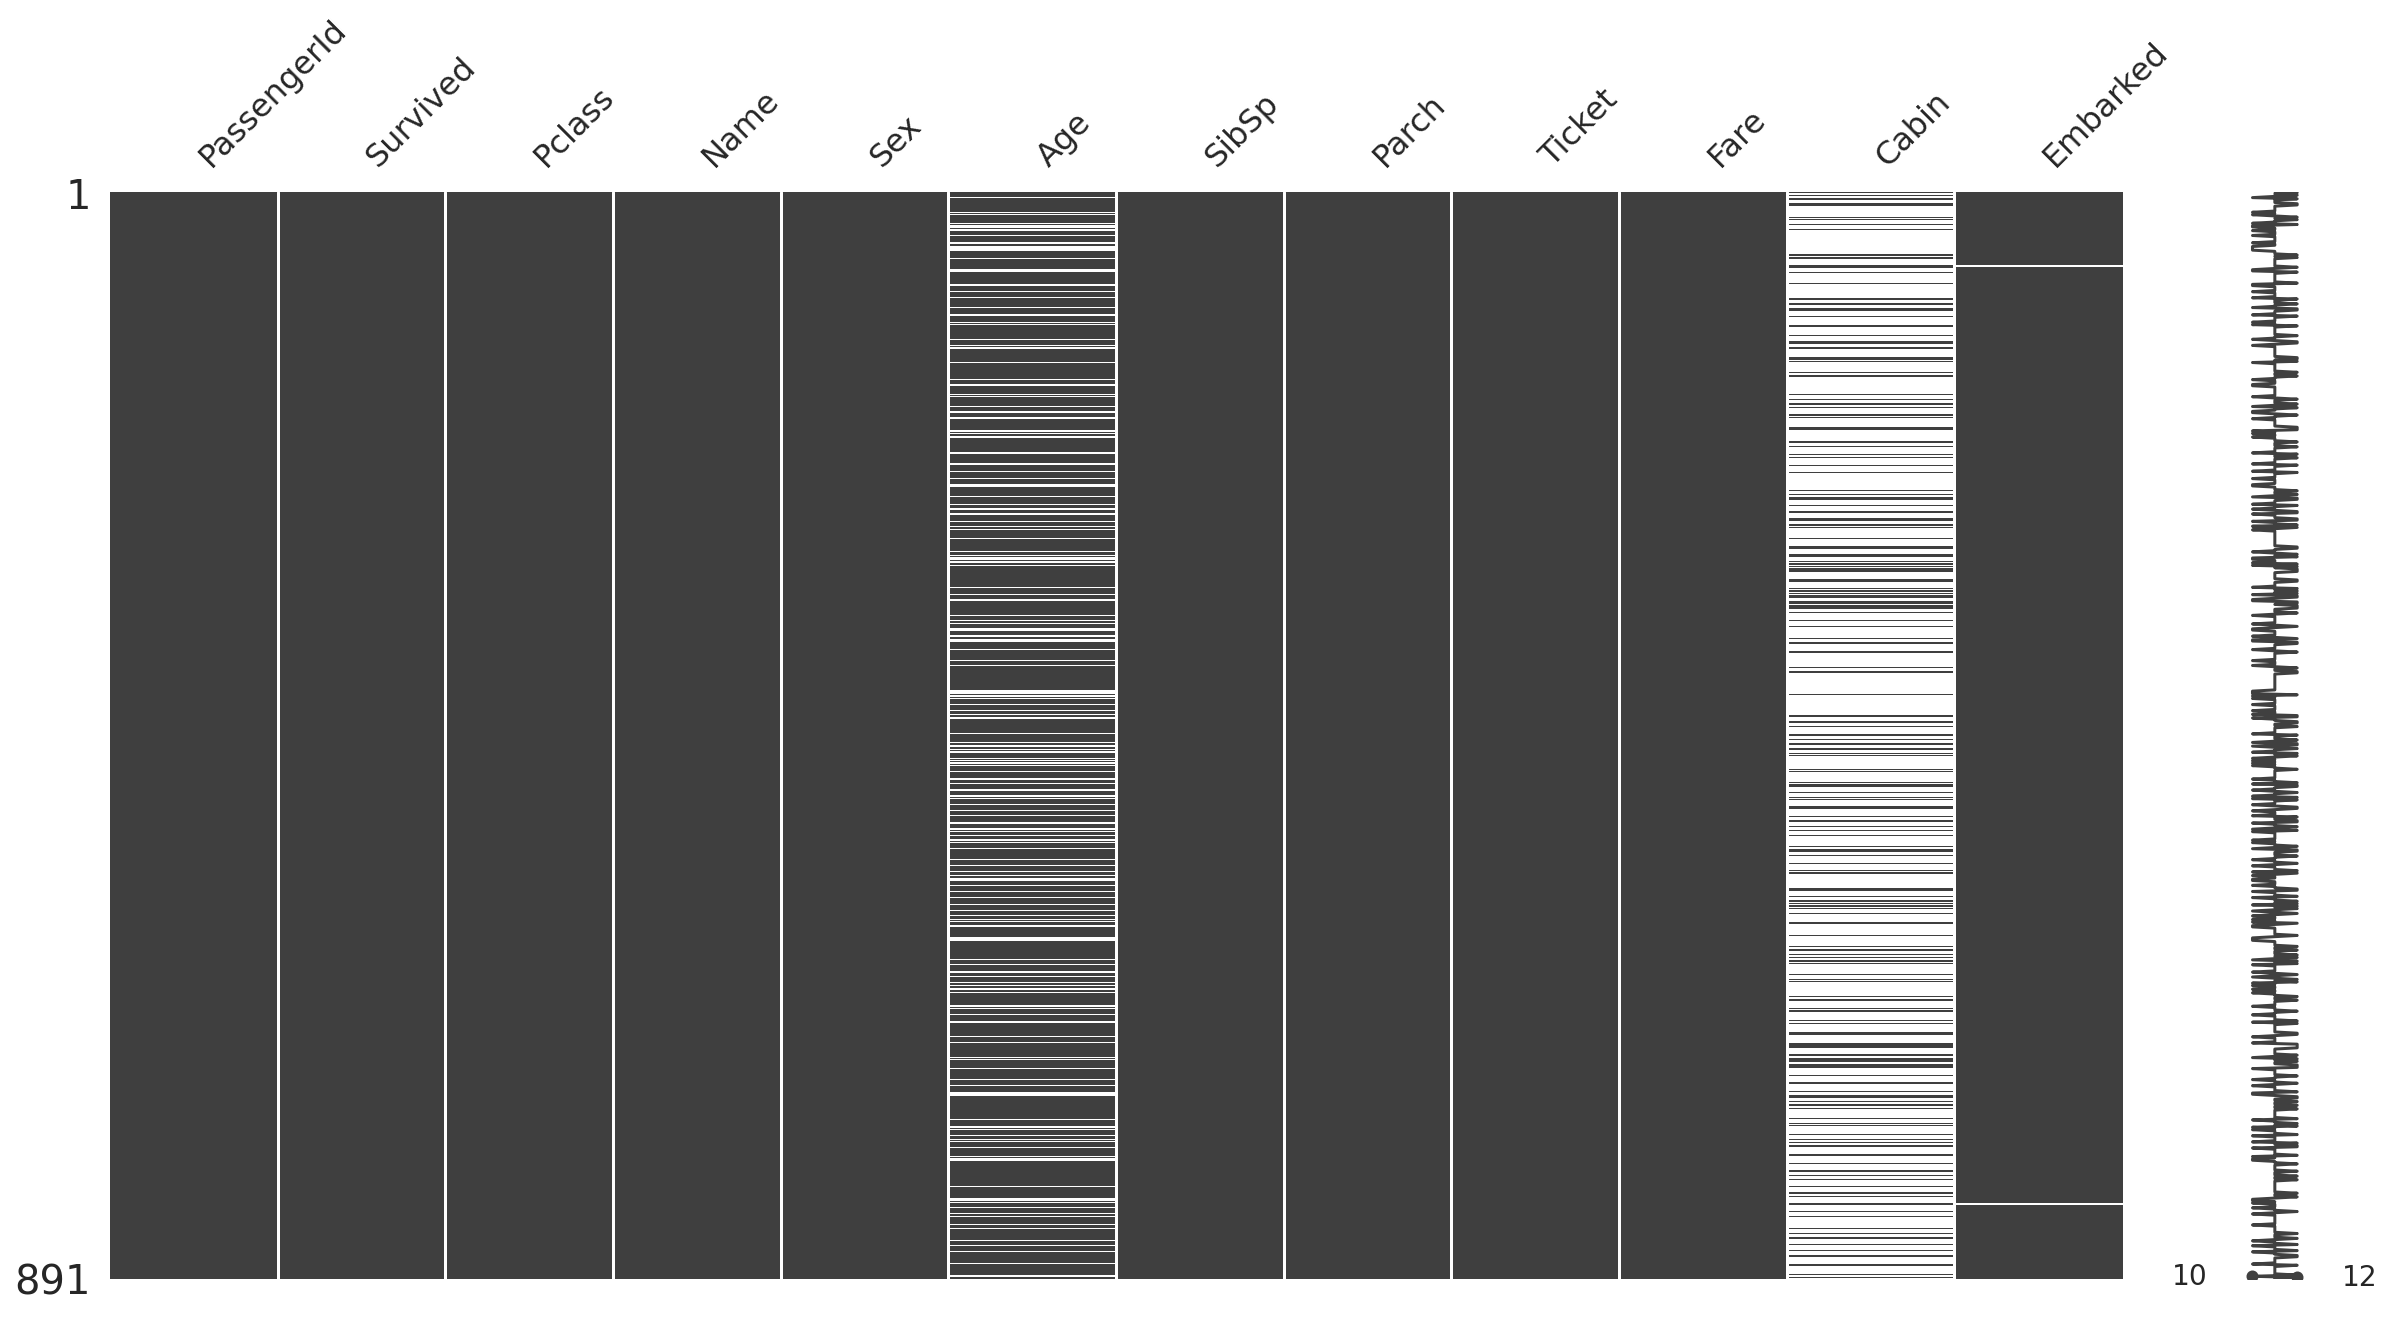

In [53]:
# Also, we can use cool visualization of the missing values of the train dataset
import missingno

missingno.matrix(data_train, figsize = (20,10))

In [54]:
data_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [55]:
# Probably it's better to get rid of Cabin feature since it has > 70% of the missing values
data_train.Cabin.isnull().sum()

687

In [56]:
# Shape with Cabin feature
data_train.shape, data_test.shape

((891, 12), (418, 11))

In [57]:
# Imputing Nan's - deleting Cabin feature
data_train = data_train.drop(labels='Cabin', axis=1)
data_test = data_test.drop(labels='Cabin', axis=1)

# Shape without Cabin feature
data_train.shape, data_test.shape

((891, 11), (418, 10))

In [58]:
# Imputing Nan's - working with Age feature because we have some outliers in the dataset
# that's why we are using the median instead of the mean it's more robust when we have outliers in the dataset
data_train.Age = data_train.Age.fillna(data_train.Age.median())
data_test.Age = data_test.Age.fillna(data_test.Age.median())

In [59]:
data_train.Age.mean(), data_train.Age.median()

(29.36158249158249, 28.0)

As we can see the Age feature distributiona hasn't changed much after the imputation meaning that we have done, possibly, the right thing.

In [60]:
# Imputing Nan's - working with Embarked feature
# since we have only 2 NaN's let's inpute using ffill

data_train.Embarked = data_train.Embarked.fillna(method='ffill')
data_test.Embarked = data_test.Embarked.fillna(method='ffill')

In [61]:
# Also, let's drop the name feature as it is useless for our prediction (probably)
data_train = data_train.drop(labels='Name', axis=1)
data_test = data_test.drop(labels='Name', axis=1)

In [62]:
# Also, let's drop the feature Ticket as it is useless for our prediction (probably)
data_train = data_train.drop(labels='Ticket', axis=1)
data_test = data_test.drop(labels='Ticket', axis=1)

In [63]:
# Also, let's make a OHE of the Embarked Feature 

#encoder = OneHotEncoder(handle_unknown = "ignore", sparse = False)
data_train.Embarked = pd.get_dummies(data_train.Embarked)
data_test.Embarked = pd.get_dummies(data_test.Embarked)


# # One-hot encoding removed index; put it back
# OH_cols_train.index = X_train.index
# OH_cols_valid.index = X_valid.index

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

To summarize, we have used the following approaches:
- deleting Nan's because the Cabin feature has > 70% of the missing values, 
- imputing median value to the Age feature as it's more robust to the outliers 
- used ffill for the Embarked feature as it has only a couple of missing value so it doesn't which we have used - it's better then just dropping several rows.

Probably, if had more time, I would investigate into the Cabin feature and found the way to impute it (filling Nan's with zeros and creating additional feature representuing the fact that those 0's were imputed).
Also, I think I can try to use Name and Ticket features, but I need to scale them down, maybe apply PCA?

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [64]:
# Split the dataframe into data and labels (X and y)
X_train = data_train.drop('Survived', axis=1) # data
X_test = data_test # test data
y_train = data_train['Survived'] # labels

In [65]:
# Check the shape
X_train.shape, y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [66]:
X_train

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,0,22.0,1,0,7.2500,0
1,2,1,1,38.0,1,0,71.2833,1
2,3,3,1,26.0,0,0,7.9250,0
3,4,1,1,35.0,1,0,53.1000,0
4,5,3,0,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...
886,887,2,0,27.0,0,0,13.0000,0
887,888,1,1,19.0,0,0,30.0000,0
888,889,3,1,28.0,1,2,23.4500,0
889,890,1,0,26.0,0,0,30.0000,1


In [67]:
X_test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           1
Embarked       0
dtype: int64

In [68]:
X_test.Fare = X_test.Fare.fillna(method='ffill')

In [69]:
# Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc  = sc.fit_transform(X_test)

In [70]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train_sc, y_train)
    acc = round(model.score(X_train_sc, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train_sc, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

In [71]:
# Logistic Regression

start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train_sc, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 80.02
Accuracy CV 10-Fold: 79.35
Running Time: 0:00:01.477797


In [72]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train_sc, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 85.63
Accuracy CV 10-Fold: 79.8
Running Time: 0:00:00.127085


In [73]:
# # Make predictions using LR
# lr_model = LogisticRegression().fit(X_train_sc,y_train) 
# predictions_lr = lr_model.predict(X_test_sc)


In [79]:
# KNN -> I've used this one
knn_model = KNeighborsClassifier().fit(X_train_sc,y_train) 
predictions_knn = knn_model.predict(X_test_sc)

In [80]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = X_test['PassengerId']
submission['Survived'] = predictions_knn # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [81]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [82]:
# Are our test and submission dataframes the same length?
if len(submission) == len(X_test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [83]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/RS_School/ml-intro-2021/ml-intro-2021/5_classification_linear_knn/knn_submission_2.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


First

NickKur1989
Results: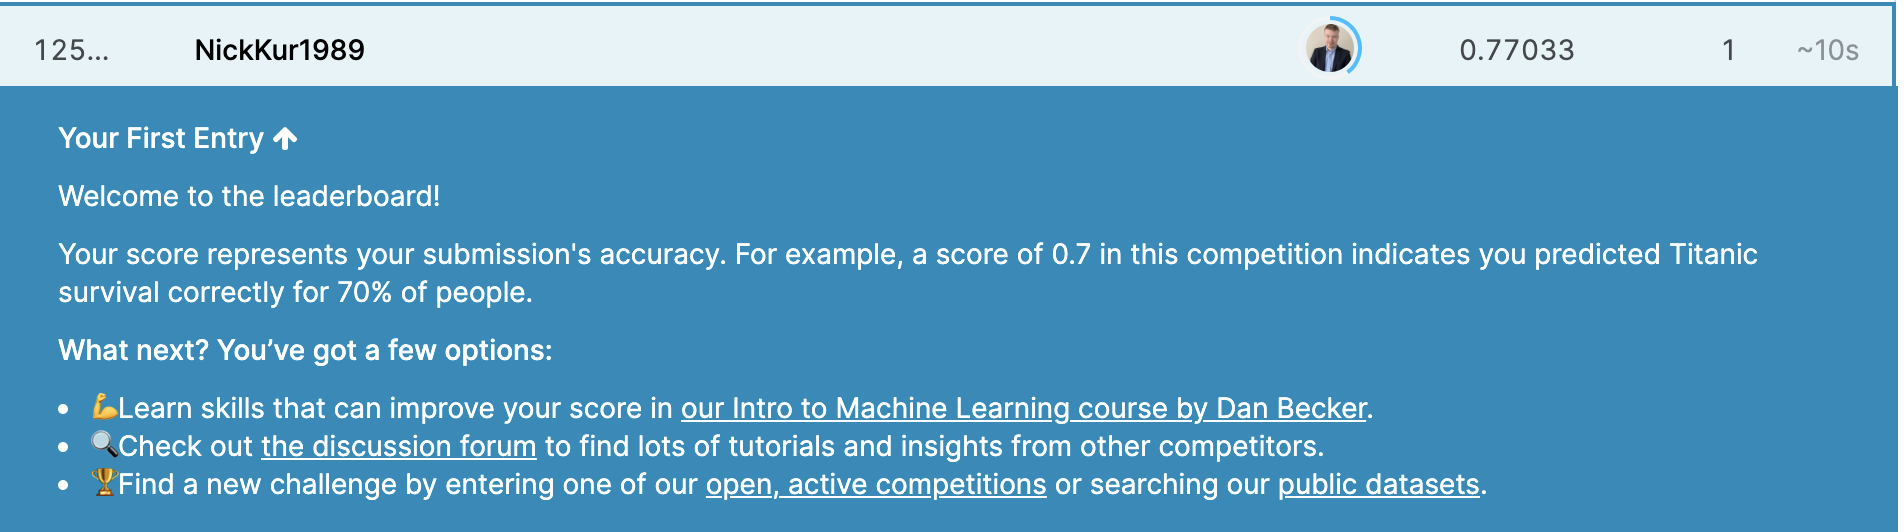
0.77033 


Second -> 0.75

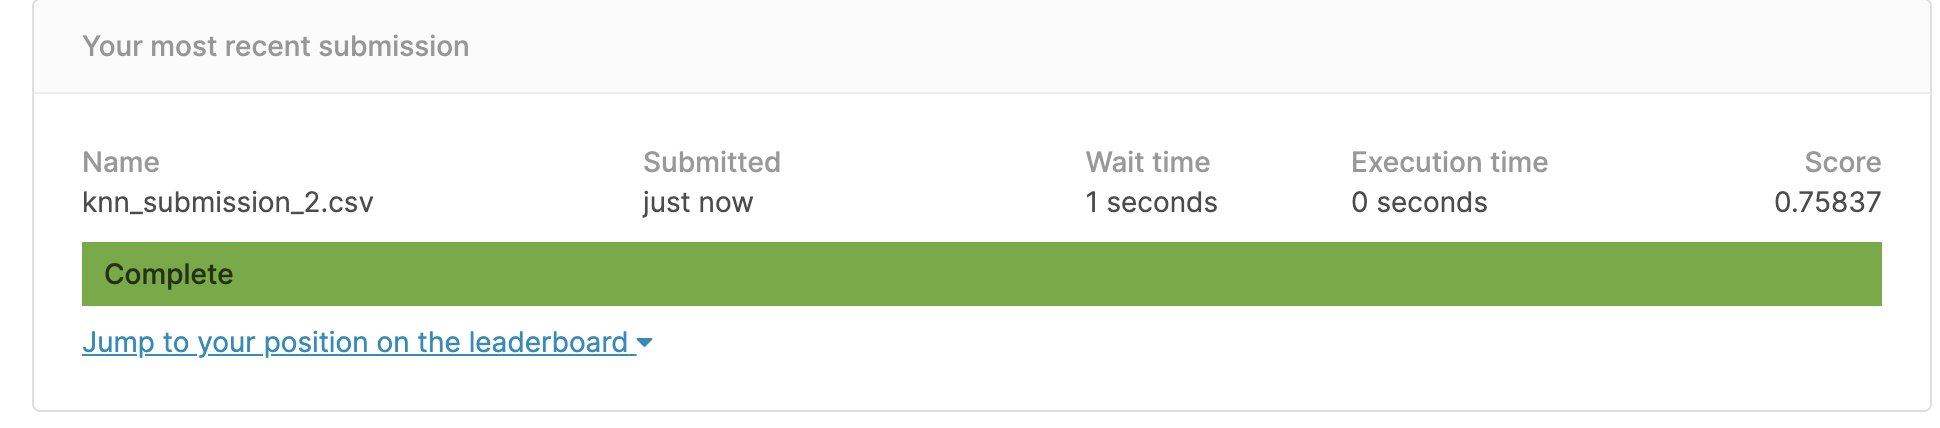

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [5]:
## your code  -> НЕ УСПЕЛ НУЖЕН БАГ ФИКС

# accessing data via GDOC
data_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RS_School/ml-intro-2021/ml-intro-2021/5_classification_linear_knn/titanic/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RS_School/ml-intro-2021/ml-intro-2021/5_classification_linear_knn/titanic/test.csv')


# ALTERNATIVE for CABIN
# Imputing Nan's - deleting Cabin feature
data_train.Cabin = data_train.Cabin.fillna(0)
data_test.Cabin = data_test.Cabin.fillna(0)



# Shape without Cabin feature
#data_train.shape, data_test.shape

# Imputing Nan's - working with Age feature because we have some outliers in the dataset
# that's why we are using the median instead of the mean it's more robust when we have outliers in the dataset
data_train.Age = data_train.Age.fillna(data_train.Age.median())
data_test.Age = data_test.Age.fillna(data_test.Age.median())

# Imputing Nan's - working with Embarked feature
# since we have only 2 NaN's let's inpute using ffill

data_train.Embarked = data_train.Embarked.fillna(method='ffill')
data_test.Embarked = data_test.Embarked.fillna(method='ffill')

# Also, let's drop the name feature as it is useless for our prediction (probably)
data_train = data_train.drop(labels='Name', axis=1)
data_test = data_test.drop(labels='Name', axis=1)

# Also, let's drop the feature Ticket as it is useless for our prediction (probably)
data_train = data_train.drop(labels='Ticket', axis=1)
data_test = data_test.drop(labels='Ticket', axis=1)


# Also, let's make a OHE of the Embarked Feature 

#encoder = OneHotEncoder(handle_unknown = "ignore", sparse = False)
data_train.Embarked = pd.get_dummies(data_train.Embarked)
data_test.Embarked = pd.get_dummies(data_test.Embarked)
data_train.Cabin = pd.get_dummies(data_train.Cabin)
data_test.Cabin = pd.get_dummies(data_test.Cabin)

# Split the dataframe into data and labels (X and y)
X_train = data_train.drop('Survived', axis=1) # data
X_test = data_test # test data
y_train = data_train['Survived'] # labels

X_test.Fare = X_test.Fare.fillna(method='ffill')

# Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc  = sc.fit_transform(X_test)

# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train_sc, y_train)
    acc = round(model.score(X_train_sc, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train_sc, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

ValueError: ignored

In [ ]:
# Logistic Regression

start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train_sc, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

In [ ]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train_sc, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

In [ ]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = X_test['PassengerId']
submission['Survived'] = predictions_knn # our model predictions on the test dataset
submission.head()

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [ ]:
## your code
# Вверху есть


## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [ ]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

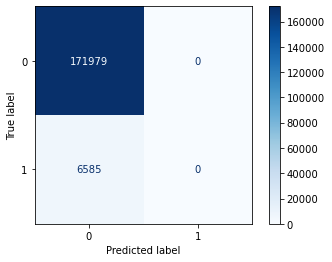

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

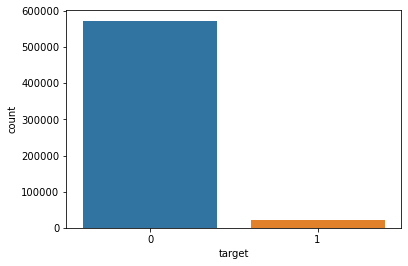

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code